<a href="https://colab.research.google.com/github/ashaaher/Emerging-Technologies/blob/master/Assignment%202/Assignment_2_Part_2/C_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Training a State-of-the-Art Model using fastai**

**Dataset Used :** 
CIFAR10: 60,000 32×32-pixel color images in 10 classes 

### **Understanding of Progressive Resizing,Mixup,Label Smoothing, Cutout and Time Test Augmentation**
**1) Progressive Resizing:** It is an another form of Data Augmentation therefore we can expect better generalization of the model that is trained with progressive resizing.
Progressive resizing is start training using small images, and end training using large images. Spending most of the epochs training with small images, helps training complete much faster. Completing training using large images makes the final accuracy much higher.

**2) Mixup:** Mixup is very powerful data augmentation technique that provides higher accuracy.When we do not have much data or any pretrained model which was trained on same dataset we are using mixup helps boots performance in such cases.

**3) Time Test Augmentation:**  During validation or inference, creating multiple versions of each image using data augmentation and then taking average or maximum of the predictions for each augmented version of the image.
Depending on Dataset, Test Time augmentation can help in increased accuracy.


In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

###Importing Fastbook

In [2]:
from fastbook import *

###Loading CIFAR dataset into a DataLoaders object 

In [3]:
from fastai.vision.all import *
#path = untar_data(URLs.IMAGENETTE)

In [4]:
path = untar_data(URLs.CIFAR)

In [5]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

### Doing a Training run that will serve as a baseline

In [6]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)



epoch,train_loss,valid_loss,accuracy,time
0,1.430894,1.906714,0.401500,11:34
1,1.033549,1.046034,0.629833,11:37
2,0.793301,0.843580,0.711500,11:36
3,0.620378,0.583736,0.796417,11:37
4,0.527582,0.512798,0.824250,11:37


### Normalization Of data


If your input data is normalized it helps training in model.

below is batch of data and we are averaging values over all axes except for the channel axis, which is axis 1:

In [8]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4706, 0.4661, 0.4465], device='cuda:0'),
 TensorImage([0.2581, 0.2598, 0.2763], device='cuda:0'))

Normalizing the data is easy to do in fastai by adding the Normalize transform. This acts on a whole mini-batch at once, so you can add it to the batch_tfms section of your data block. You need to pass to this transform the mean and standard deviation that you want to use; fastai comes with the standard ImageNet mean and standard deviation already defined. (If you do not pass any statistics to the Normalize transform, fastai will automatically calculate them from a single batch of your data.)



Let's add this transform (using cifar_stats) and take a look at one batch now:

In [9]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*cifar_stats)])
    return dblock.dataloaders(path, bs=bs)

In [10]:
dls = get_dls(64, 224)

In [11]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([ 0.0394, -0.0134, -0.0387], device='cuda:0'),
 TensorImage([0.9623, 0.9841, 0.9554], device='cuda:0'))

Checking the effects on training our model:

In [12]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.424637,1.716498,0.413750,11:38
1,1.028185,1.024531,0.636000,11:38
2,0.804904,0.764113,0.733000,11:38
3,0.609056,0.540615,0.810917,11:38
4,0.519125,0.483907,0.832250,11:39


### Progressive Resizing


We use the fine_tune method after we resize our images because We are trying to get our model to learn to do something a little bit different from what it has learned to do before. 

To implement progressive resizing we first create a get_dls function which takes an image size and a batch size and returns DataLoaders:

with this DataLoaders we can create small size and use fit_one_cycle and training for a few less epochs.

In [13]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.344674,1.266041,0.548083,05:01
1,0.922638,1.055648,0.632000,05:01
2,0.653384,0.575052,0.801583,05:01
3,0.505418,0.475682,0.840583,05:00


### Replacing DataLoaders inside the Learner and fine-tune:

In [14]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.690791,0.681267,0.763167,11:38


epoch,train_loss,valid_loss,accuracy,time
0,0.528962,0.489661,0.831583,11:39
1,0.487093,0.448520,0.841833,11:38
2,0.453208,0.413276,0.852833,11:38
3,0.327653,0.317869,0.889917,11:37
4,0.313395,0.300517,0.895167,11:38


-------------till here ------------------

### Test Time Augmentation

As We can see initial training on small images is much faster on each epoch.

In order to use TTA , we can pass any DataLoader to fastai's tta method.

TTA does not change the time required to train at all, but will increase the amount of time required for validation or inference by the number of test-time-augmented images requested. By default, fastai uses the unaugmented center crop image plus four randomly augmented images.



In [15]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9011666774749756

### Mixup

TTA gives us good a boost in performance, with no additional training required. However, it does make inference slower—if you're averaging five images for TTA, inference will be five times slower.

Below are the steps how mixup works for each image:
1) Select random image from dataset
2) Pick a random weight.
3) Take a weighted average (using the weight which we got in second step) of the selected image with your image. this is independent variable.
4) Take a weighted average (with the same weight) of this image's labels with your image's labels; this is dependent variable.

Below is the formula: (where t is the weight for our weighted average):

image2,target2 = dataset[randint(0,len(dataset)]
t = random_float(0.5,1.0)
new_image = t * image1 + (1-t) * image2
new_target = t * target1 + (1-t) * target2

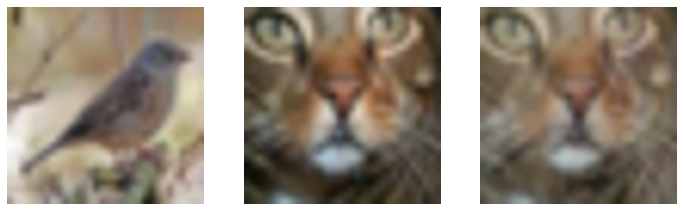

In [25]:

#hide_input
#id mixup_example
#caption Mixing a church and a gas station
#alt An image of a church, a gas station and the two mixed up.
sparrow = PILImage.create(get_image_files_sorted(path/'train'/'bird')[0])
cat = PILImage.create(get_image_files_sorted(path/'train'/'cat')[0])
sparrow = sparrow.resize((256,256))
cat = cat.resize((256,256))
tsparrow = tensor(sparrow).float() / 255.
tcat = tensor(cat).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tsparrow, ax=axs[0]);
show_image(tcat, ax=axs[1]);
show_image((0.3*tsparrow + 0.7*tcat), ax=axs[2]);

The third image is built by adding 0.3 times the first one and 0.7 times the second image.

### Training The model with mixup

In [22]:
Mixup =MixUp(0.5)
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=Mixup)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.800539,1.499585,0.449417,05:01
1,1.522922,1.114843,0.614333,05:02
2,1.346378,0.892299,0.696083,05:01
3,1.206861,0.663915,0.787833,05:02
4,1.136513,0.570739,0.822667,05:04
